# discrete_tf - Example2

Very simple discrete transfer function.

![](discrete_tf.png)

# Python Setup

In [1]:
import ctypes
from rtwtypes import *

In [2]:
import os
dll_path = os.path.abspath('discrete_tf_win64.dll')
dll = ctypes.windll.LoadLibrary(dll_path)
# Model entry point functions
model_initialize = dll.discrete_tf_initialize
model_step = dll.discrete_tf_step
model_terminate = dll.discrete_tf_terminate

In [3]:
InputSignal = real_T.in_dll(dll, 'InputSignal')
num = (real_T*2).in_dll(dll,  "num")
den = (real_T*2).in_dll(dll,  "den")

In [4]:
OutputSignal = real_T.in_dll(dll, 'OutputSignal')
SimTime = real_T.in_dll(dll, 'SimTime')

Validate that the transfer function numerator and denominator generated in Matlab match those generated with Python tools.

```
matlab tf() -> matlab c2d() -> Simulink Tunable Parameter -> dll -> Python == control.c2d(control.TransfenFunction)
```

In [5]:
import control
import numpy as np
# How fast the simulink model is running.
Ts=1e-3
# Static Gain
K = 3
# Time Constant.
tau = 2
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.00149963]), array([ 1.        , -0.99950012]), 0.001)

In [6]:
list(num)

[0.0, 0.0014996250624921886]

In [7]:
list(den)

[1.0, -0.9995001249791693]

In [8]:
np.isclose(num[1], sysd.num)

array([[[ True]]])

In [10]:
np.isclose(den[:], sysd.den)

array([[[ True,  True]]])

# Running The Model.

Run the model and store the step, input, output and simulation time to a pandas dataframe.

In [11]:
model_initialize();
rows = list()
for step in range(1000):
    row_tmp = {
    'step': model_step(),
    'time': float(SimTime.value),
    'input': float(InputSignal.value),
    'output': float(OutputSignal.value),
    }
    rows.append(row_tmp)

In [12]:
import pandas as pd
df = pd.DataFrame(rows)
df

,step,time,input,output
0,0,0.000,0.0,0.0
1,1,0.001,0.0,0.0
2,2,0.002,0.0,0.0
3,3,0.003,0.0,0.0
4,4,0.004,0.0,0.0
...,...,...,...,...
995,995,0.995,0.0,0.0
996,996,0.996,0.0,0.0
997,997,0.997,0.0,0.0
998,998,0.998,0.0,0.0


<AxesSubplot:xlabel='step'>

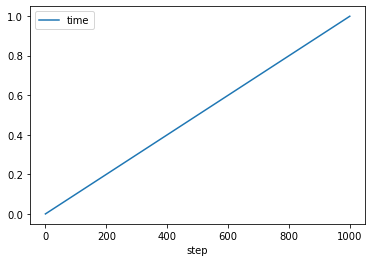

In [13]:
df.plot("step", "time")

# Step Response

Generate a step response to test the transfer function.

Unit step @ 1s.

In [14]:
model_initialize();
InputSignal.value=0.0;
rows = list()
for step in range(int(15*1e3)):
    if step>=1*1e3:
        InputSignal.value=1.0
    else:
        InputSignal.value=0.0
    row_tmp = {
    'step': model_step(),
    'time': float(SimTime.value),
    'input': float(InputSignal.value),
    'output': float(OutputSignal.value),
    }
    rows.append(row_tmp)
df = pd.DataFrame(rows)
df

,step,time,input,output
0,0,0.000,0.0,0.000000
1,1,0.001,0.0,0.000000
2,2,0.002,0.0,0.000000
3,3,0.003,0.0,0.000000
4,4,0.004,0.0,0.000000
...,...,...,...,...
14995,14995,14.995,1.0,2.997258
14996,14996,14.996,1.0,2.997259
14997,14997,14.997,1.0,2.997260
14998,14998,14.998,1.0,2.997262


<AxesSubplot:xlabel='time'>

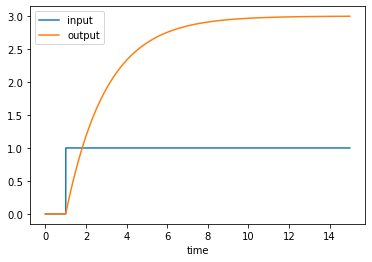

In [15]:
df.plot(x='time', y=["input", "output"])

Text(0.5, 1.0, 'Step response modeled in Python')

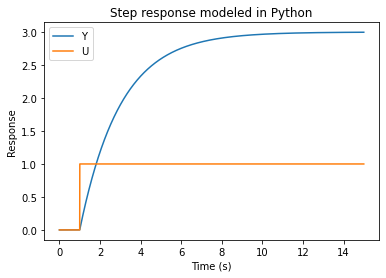

In [21]:
T, yout, xout = control.forced_response(sysd, df.time, df.input)

plt.plot(T, yout, T, df.input)
plt.legend(["Y", "U"])
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.title("Step response modeled in Python")

In [22]:
# Max error
np.max(yout-df.output)

9.903189379656396e-14

Sending the Simulink shared library has the same response (as it should) to the same signal tested with the python `control` library. Therefore it is reasonable to assume all other higher level algorithms tested on Simulink should work correctly in Python.

# Sinewave Input

Generate a sinewave with ``numpy``. Plot the input and output of the transfer function with ``pandas``.

<AxesSubplot:xlabel='time'>

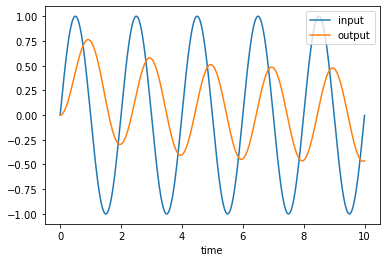

In [23]:
model_initialize();
rows = list()
f = 0.5 # Hz
for step in range(int(10*1e3)):
    InputSignal.value=np.sin(2*np.pi*step*f/1e3)
    row_tmp = {
    'step': model_step(),
    'time': float(SimTime.value),
    'input': float(InputSignal.value),
    'output': float(OutputSignal.value),
    }
    rows.append(row_tmp)
df = pd.DataFrame(rows)
df.plot(x='time', y=["input", "output"])

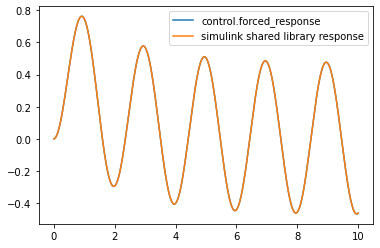

In [25]:
T, yout, _ = control.forced_response(sysd, df.time, df.input)
plt.plot(T, yout, df.time, df.output)
plt.legend(["control.forced_response", "simulink shared library response"])

# Changing the TransferFunction

Change the transfer function to have a static gain of 1 and a timeconstant of 1s.

Mark $1\tau$ and $2\tau$ on the graph.

In [32]:
# How fast the simulink model is running.
Ts=1e-3
# Static Gain
K = 1
# Time Constant.
tau = 1
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.0009995]), array([ 1.       , -0.9990005]), 0.001)

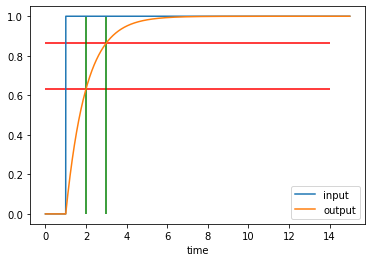

In [40]:
num[1]=sysd.num[0][0][0]
den[0] = sysd.den[0][0][0]
den[1] = sysd.den[0][0][1]

model_initialize();
InputSignal.value=0.0;
rows = list()
for step in range(int(15*1e3)):
    if step>=1*1e3:
        InputSignal.value=1.0
    else:
        InputSignal.value=0.0
    row_tmp = {
    'step': model_step(),
    'time': float(SimTime.value),
    'input': float(InputSignal.value),
    'output': float(OutputSignal.value),
    }
    rows.append(row_tmp)
df = pd.DataFrame(rows)
df.plot(x='time', y=["input", "output"])
plt.hlines([1-np.exp(-1), 1-np.exp(-2)], xmin=0, xmax=14, colors="r")
plt.vlines([2, 3], ymin=0, ymax=1, colors="g")